# Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import os

import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from scipy import linalg
from torchvision import transforms, models

%matplotlib inline
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import models
from torchmetrics.image.fid import FrechetInceptionDistance

# Setting a manual seed for reproducibility and other Hyper parameters


In [3]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
dataroot = "/kaggle/input/covid19-image-dataset/Covid19-dataset"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
ngpu = 1

Random Seed:  999


# Data Loading and Set up 

device cuda:0


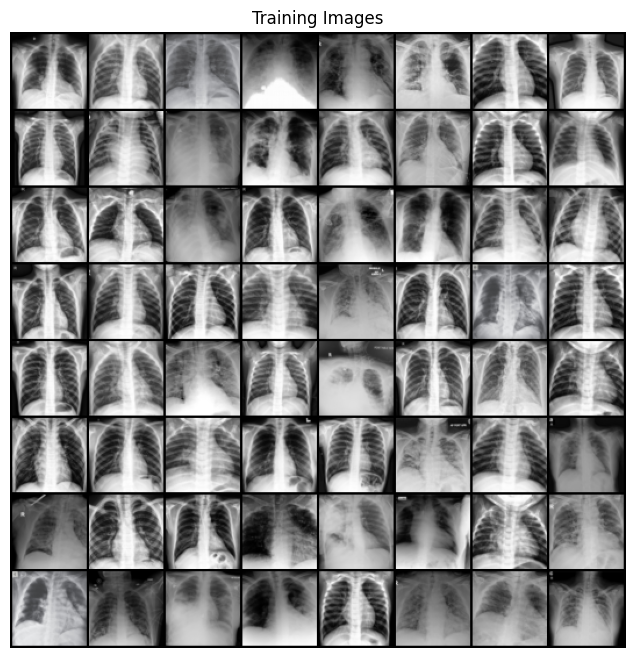

In [4]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("device", device)
# Visualization of training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


# Initialize weights

In [5]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define ResidualBlock and UNet

In [6]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.encoder_block(nc, ngf)
        self.enc2 = self.encoder_block(ngf, ngf * 2)
        self.enc3 = self.encoder_block(ngf * 2, ngf * 4)
        self.enc4 = self.encoder_block(ngf * 4, ngf * 8)

        self.res = ResidualBlock(ngf * 8)

        self.dec1 = self.decoder_block(ngf * 8, ngf * 4)
        self.dec2 = self.decoder_block(ngf * 4, ngf * 2)
        self.dec3 = self.decoder_block(ngf * 2, ngf)
        self.dec4 = nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1)

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        r = self.res(e4)

        d1 = self.dec1(r)
        d2 = self.dec2(d1)
        d3 = self.dec3(d2)
        d4 = torch.tanh(self.dec4(d3))

        return d4

# Define DiffusionModel

In [7]:

class DiffusionModel:
    def __init__(self, model, timesteps=1000):
        self.model = model.to(device)
        self.timesteps = timesteps
        self.betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), self.alpha_cumprod[:-1]])
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t):
        noise = torch.randn_like(x_start)
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise

    def p_sample(self, x_t, t):
        noise = torch.randn_like(x_t)
        return self.model(x_t) + noise * self.betas[t]

    def sample(self, x_start):
        x_t = x_start
        for t in reversed(range(self.timesteps)):
            x_t = self.p_sample(x_t, t)
        return x_t

# Define PerceptualLoss

In [8]:

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features
        self.layers = nn.Sequential(*list(vgg.children())[:16]).eval()
        for param in self.layers.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_features = self.layers(x)
        y_features = self.layers(y)
        loss = nn.functional.mse_loss(x_features, y_features)
        return loss

# Diffusion model training function

In [10]:
def train_diffusion_model_with_time(dataloader, model, diffusion_model, num_epochs, lr, beta1):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
    mse_criterion = nn.MSELoss()
    perceptual_criterion = PerceptualLoss().to(device)
    
    # Track time
    start_time = time.time()

    # Lists to keep track of progress
    img_list = []
    G_losses_epoch = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            noise = torch.randn(b_size, nc, image_size, image_size, device=device)
            t = torch.randint(0, diffusion_model.timesteps, (b_size,), device=device)

            x_t = diffusion_model.q_sample(real_cpu, t)
            output = model(x_t)

            mse_loss = mse_criterion(output, real_cpu)
            perceptual_loss = perceptual_criterion(output, real_cpu)
            loss = mse_loss + 0.1 * perceptual_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if i % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] Loss: {loss.item()} MSE Loss: {mse_loss} Perceptual Loss: {perceptual_loss}')
        scheduler.step()

        # Store epoch loss
        G_losses_epoch.append(epoch_loss / len(dataloader))

        # Check how the generator is doing by saving G's output on fixed_noise
        with torch.no_grad():
            fake = model(noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    end_time = time.time()
    training_time = end_time - start_time

    return G_losses_epoch, img_list, training_time


# Calculate FID score

In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from scipy import linalg
import numpy as np
from PIL import Image

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Inception v3 model
inception_model = models.inception_v3(pretrained=True, aux_logits=True).to(device)
inception_model.eval()

# Modify Inception v3 to output features from an intermediate layer
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
    
    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, start_dim=1)

feature_extractor = FeatureExtractor(inception_model).to(device)

# Helper function to get Inception v3 features
def get_inception_features(images, model, batch_size=32):
    features_list = []
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = torch.stack([preprocess(img) for img in batch]).to(device)
        with torch.no_grad():
            features = model(batch).detach().cpu().numpy()
        features_list.append(features)
    
    return np.concatenate(features_list, axis=0)

# Calculate mean and covariance of features
def calculate_activation_statistics(features):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

# Calculate FID score
def calculate_fid(real_images, generated_images, model, eps=1e-6):
    real_features = get_inception_features(real_images, model)
    gen_features = get_inception_features(generated_images, model)
    
    mu_real, sigma_real = calculate_activation_statistics(real_features)
    mu_gen, sigma_gen = calculate_activation_statistics(gen_features)
    
    # Calculate the Frechet distance
    diff = mu_real - mu_gen
    
    # Add small epsilon to the covariance matrices to ensure positive definiteness
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_gen) + np.eye(sigma_real.shape[0]) * eps, disp=False)
    
    # Check if covmean is complex and take the real part if necessary
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_gen - 2*covmean)
    
    # Ensure FID is non-negative
    return max(fid, 0)


# Function to generate images

In [13]:

def generate_images(model, diffusion_model, num_images):
    with torch.no_grad():
        noise = torch.randn(num_images, nc, image_size, image_size, device=device)
        generated_images = diffusion_model.sample(noise)
        return generated_images


# Setting up Hyperparameters

In [14]:

best_fid = float('inf')
best_model_params = None
hyperparams_list = [
    {'lr': 0.0001, 'beta1': 0.5},
    {'lr': 0.0001, 'beta1': 0.7},
    {'lr': 0.001, 'beta1': 0.5},
    {'lr': 0.001, 'beta1': 0.7},
]


# Running training on hyperparameters to get best set of hyperparameters

In [15]:
num_epochs=200
for params in hyperparams_list:
    print(f"Training with hyperparameters: {params}")
    
    model = UNet().apply(weights_init).to(device)
    diffusion_model = DiffusionModel(model)
    
    G_losses, img_list_diff, training_time_diff = train_diffusion_model_with_time(dataloader, model, diffusion_model, num_epochs, params['lr'], params['beta1'])
    print(f"Model's time taken - {training_time_diff}")
    with torch.no_grad():
        fake_images = generate_images(model, diffusion_model, len(dataloader.dataset))
        real_images = next(iter(dataloader))[0].to(device)
        
        # Convert to PIL images for Inception v3
        real_images_pil = [transforms.ToPILImage()(img.cpu()) for img in real_images]
        fake_images_pil = [transforms.ToPILImage()(img.cpu()) for img in fake_images]
        
        fid_score = calculate_fid(real_images_pil, fake_images_pil, inception_model)
    
    print(f"FID score: {fid_score}")
    
    if fid_score < best_fid:
        best_fid = fid_score
        best_model_params = params
        torch.save(model.state_dict(), "best_model.pth")

print(f"Best hyperparameters: {best_model_params}")

Training with hyperparameters: {'lr': 0.0001, 'beta1': 0.5}


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]  


Epoch [1/200] Batch [0/3] Loss: 1.1917258501052856 MSE Loss: 0.3294772505760193 Perceptual Loss: 8.622486114501953
Epoch [2/200] Batch [0/3] Loss: 1.049149751663208 MSE Loss: 0.3228403925895691 Perceptual Loss: 7.263093948364258
Epoch [3/200] Batch [0/3] Loss: 1.0431329011917114 MSE Loss: 0.3239440619945526 Perceptual Loss: 7.191888809204102
Epoch [4/200] Batch [0/3] Loss: 0.9790827035903931 MSE Loss: 0.3040105998516083 Perceptual Loss: 6.750720977783203
Epoch [5/200] Batch [0/3] Loss: 0.9671511054039001 MSE Loss: 0.2982316017150879 Perceptual Loss: 6.689195156097412
Epoch [6/200] Batch [0/3] Loss: 0.9313014149665833 MSE Loss: 0.2866770029067993 Perceptual Loss: 6.446243762969971
Epoch [7/200] Batch [0/3] Loss: 0.8888789415359497 MSE Loss: 0.2686710059642792 Perceptual Loss: 6.202078819274902
Epoch [8/200] Batch [0/3] Loss: 0.8821142911911011 MSE Loss: 0.2577790319919586 Perceptual Loss: 6.243351936340332
Epoch [9/200] Batch [0/3] Loss: 0.8197868466377258 MSE Loss: 0.23744332790374756 

# Training the Diffusion model with best hyperparameters

In [16]:
num_epochs = 250
best_model = UNet().apply(weights_init).to(device)
best_diffusion_model = DiffusionModel(best_model)
G_losses_diff, img_list, training_time_best_model = train_diffusion_model_with_time(dataloader, best_model, best_diffusion_model, num_epochs, best_model_params['lr'], best_model_params['beta1'])

Epoch [1/250] Batch [0/3] Loss: 1.0925734043121338 MSE Loss: 0.3000984787940979 Perceptual Loss: 7.92474889755249
Epoch [2/250] Batch [0/3] Loss: 1.0981121063232422 MSE Loss: 0.31447768211364746 Perceptual Loss: 7.8363447189331055
Epoch [3/250] Batch [0/3] Loss: 0.9757506847381592 MSE Loss: 0.294862300157547 Perceptual Loss: 6.808883190155029
Epoch [4/250] Batch [0/3] Loss: 0.927499532699585 MSE Loss: 0.26539120078086853 Perceptual Loss: 6.6210832595825195
Epoch [5/250] Batch [0/3] Loss: 0.8877900838851929 MSE Loss: 0.23634836077690125 Perceptual Loss: 6.514416694641113
Epoch [6/250] Batch [0/3] Loss: 0.8175278902053833 MSE Loss: 0.208461731672287 Perceptual Loss: 6.090662002563477
Epoch [7/250] Batch [0/3] Loss: 0.7532005310058594 MSE Loss: 0.17495545744895935 Perceptual Loss: 5.7824506759643555
Epoch [8/250] Batch [0/3] Loss: 0.7348261475563049 MSE Loss: 0.16354316473007202 Perceptual Loss: 5.71282958984375
Epoch [9/250] Batch [0/3] Loss: 0.7177987694740295 MSE Loss: 0.15697784721851

# Plot generator losses for Diffusion Model

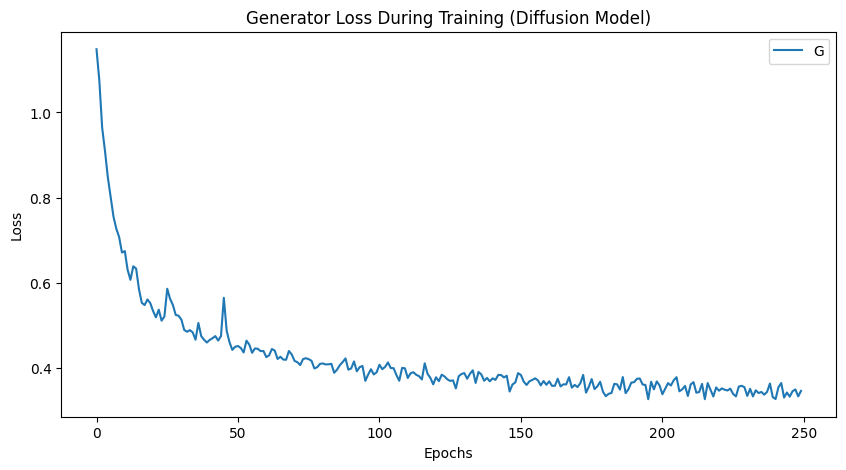

In [ ]:

plt.figure(figsize=(10, 5))
plt.title("Generator Loss During Training (Diffusion Model)")
plt.plot(G_losses_diff, label="G")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Defining Generator for DC-GANS

In [18]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [19]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Defining Discriminator for DC-GANS

In [20]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [21]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Image Generator for DC-GANS

In [22]:
def generate_images_dcgan(generator, num_images, nz):
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    return generated_images

# DC-GANS Training Function

In [23]:
def train_dcgan_with_fid(dataloader, netG, netD, num_epochs, lr, beta1):
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    real_label = 1.
    fake_label = 0.
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Track time
    start_time = time.time()

    # Lists to keep track of progress
    img_list = []
    G_losses_epoch = []
    D_losses_epoch = []

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        epoch_G_loss = 0
        epoch_D_loss = 0
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            epoch_G_loss += errG.item()
            epoch_D_loss += errD.item()

            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Store epoch losses
        G_losses_epoch.append(epoch_G_loss / len(dataloader))
        D_losses_epoch.append(epoch_D_loss / len(dataloader))

        if (epoch == num_epochs-1):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    end_time = time.time()
    training_time = end_time - start_time

    # Generate images and calculate FID score
    real_images = next(iter(dataloader))[0].to(device)
    real_images_pil = [transforms.ToPILImage()(img.cpu()) for img in real_images]
    fake_images = generate_images_dcgan(netG, len(dataloader.dataset), nz)
    fake_images_pil = [transforms.ToPILImage()(img.cpu()) for img in fake_images]
    fid_score = calculate_fid(real_images_pil, fake_images_pil, inception_model)

    return G_losses_epoch, D_losses_epoch, img_list, training_time, fid_score



# Hyperparameter tuning for DCGAN


In [24]:

best_fid_dcgan = float('inf')
best_dcgan_params = None
hyperparams_list_dcgan = [
    {'lr': 0.0001, 'beta1': 0.5},
    {'lr': 0.0001, 'beta1': 0.7},
    {'lr': 0.001, 'beta1': 0.5},
    {'lr': 0.001, 'beta1': 0.7},
]


# Hyperparameter tuning on DC-GANS and getting best parameters

In [27]:
num_epochs = 200
for params in hyperparams_list_dcgan:
    print(f"Training DCGAN with hyperparameters: {params}")

    netG = Generator(ngpu).apply(weights_init).to(device)
    netD = Discriminator(ngpu).apply(weights_init).to(device)

    G_losses_dcgan, D_losses_dcgan, img_list_dcgan, training_time_dcgan, fid_score_dcgan = train_dcgan_with_fid(
        dataloader, netG, netD, num_epochs, params['lr'], params['beta1']
    )

    print(f"FID score: {fid_score_dcgan}")

    if fid_score_dcgan < best_fid_dcgan:
        best_fid_dcgan = fid_score_dcgan
        best_dcgan_params = params
        torch.save(netG.state_dict(), "best_dcgan_generator.pth")
        torch.save(netD.state_dict(), "best_dcgan_discriminator.pth")

print(f"Best hyperparameters for DCGAN: {best_dcgan_params}")

Training DCGAN with hyperparameters: {'lr': 0.0001, 'beta1': 0.5}
Starting Training Loop...
[0/200][0/3]	Loss_D: 1.1202	Loss_G: 3.1016	D(x): 0.7443	D(G(z)): 0.4905 / 0.0642
[1/200][0/3]	Loss_D: 0.1644	Loss_G: 4.7107	D(x): 0.9775	D(G(z)): 0.1227 / 0.0144
[2/200][0/3]	Loss_D: 0.1653	Loss_G: 4.6709	D(x): 0.9653	D(G(z)): 0.1114 / 0.0140
[3/200][0/3]	Loss_D: 0.0950	Loss_G: 5.1178	D(x): 0.9805	D(G(z)): 0.0691 / 0.0090
[4/200][0/3]	Loss_D: 0.0997	Loss_G: 5.5566	D(x): 0.9824	D(G(z)): 0.0745 / 0.0063
[5/200][0/3]	Loss_D: 0.0803	Loss_G: 5.6898	D(x): 0.9896	D(G(z)): 0.0648 / 0.0053
[6/200][0/3]	Loss_D: 0.0637	Loss_G: 6.0392	D(x): 0.9876	D(G(z)): 0.0481 / 0.0038
[7/200][0/3]	Loss_D: 0.0499	Loss_G: 6.3149	D(x): 0.9871	D(G(z)): 0.0347 / 0.0028
[8/200][0/3]	Loss_D: 0.0411	Loss_G: 6.4015	D(x): 0.9908	D(G(z)): 0.0305 / 0.0026
[9/200][0/3]	Loss_D: 0.0342	Loss_G: 6.6751	D(x): 0.9926	D(G(z)): 0.0258 / 0.0021
[10/200][0/3]	Loss_D: 0.0317	Loss_G: 6.9473	D(x): 0.9897	D(G(z)): 0.0203 / 0.0016
[11/200][0/3]	Lo

# Training the DCGAN model with best hyperparameters

In [28]:

num_epochs = 250
best_netG = Generator(ngpu).apply(weights_init).to(device)
best_netD = Discriminator(ngpu).apply(weights_init).to(device)
G_losses_best_dcgan, D_losses_best_dcgan, img_list_best_dcgan, training_time_best_dcgan, _ = train_dcgan_with_fid(
    dataloader, best_netG, best_netD, num_epochs, best_dcgan_params['lr'], best_dcgan_params['beta1']
)

Starting Training Loop...
[0/250][0/3]	Loss_D: 2.2492	Loss_G: 1.5464	D(x): 0.4760	D(G(z)): 0.6834 / 0.2752
[1/250][0/3]	Loss_D: 0.6332	Loss_G: 3.5714	D(x): 0.9835	D(G(z)): 0.4000 / 0.0497
[2/250][0/3]	Loss_D: 0.2963	Loss_G: 3.9142	D(x): 0.9498	D(G(z)): 0.1939 / 0.0311
[3/250][0/3]	Loss_D: 0.2069	Loss_G: 4.3844	D(x): 0.9603	D(G(z)): 0.1356 / 0.0190
[4/250][0/3]	Loss_D: 0.1860	Loss_G: 4.6331	D(x): 0.9800	D(G(z)): 0.1402 / 0.0148
[5/250][0/3]	Loss_D: 0.1694	Loss_G: 5.0956	D(x): 0.9794	D(G(z)): 0.1278 / 0.0099
[6/250][0/3]	Loss_D: 0.1212	Loss_G: 5.3339	D(x): 0.9758	D(G(z)): 0.0864 / 0.0074
[7/250][0/3]	Loss_D: 0.0905	Loss_G: 5.6146	D(x): 0.9707	D(G(z)): 0.0510 / 0.0056
[8/250][0/3]	Loss_D: 0.0843	Loss_G: 5.8809	D(x): 0.9797	D(G(z)): 0.0552 / 0.0047
[9/250][0/3]	Loss_D: 0.1329	Loss_G: 6.2577	D(x): 0.9740	D(G(z)): 0.0918 / 0.0031
[10/250][0/3]	Loss_D: 0.0809	Loss_G: 6.1799	D(x): 0.9777	D(G(z)): 0.0517 / 0.0032
[11/250][0/3]	Loss_D: 0.0604	Loss_G: 6.6420	D(x): 0.9717	D(G(z)): 0.0257 / 0.0026


# Plot generator and discriminator losses for DCGAN

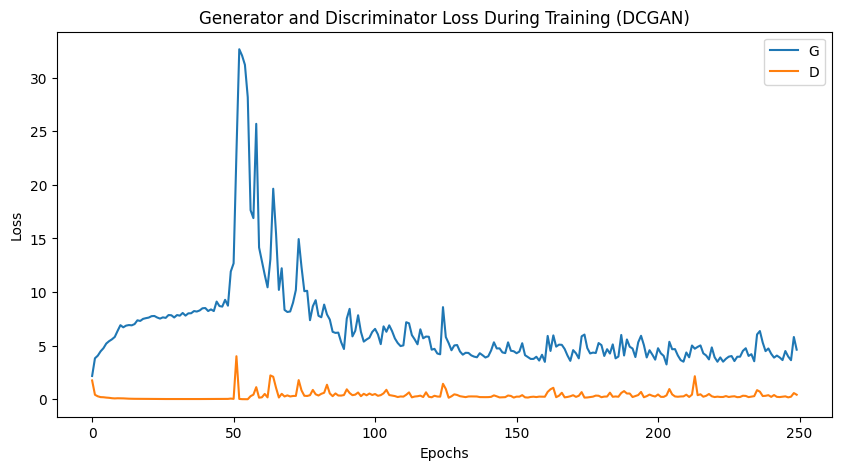

In [35]:

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training (DCGAN)")
plt.plot(G_losses_best_dcgan, label="G")
plt.plot(D_losses_best_dcgan, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate images from both models

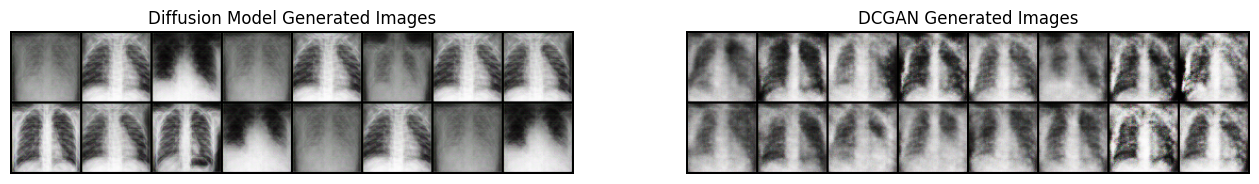

In [36]:

new_images_diff = generate_images(model, diffusion_model, 16)
fixed_noise = torch.randn(16, nz, 1, 1, device=device)
with torch.no_grad():
    new_images_best_dcgan = best_netG(fixed_noise).detach().cpu()

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Diffusion Model Generated Images")
plt.imshow(np.transpose(vutils.make_grid(new_images_diff, padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("DCGAN Generated Images")
plt.imshow(np.transpose(vutils.make_grid(new_images_best_dcgan, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

# Compare training times

In [37]:

print(f"Training Time for Diffusion Model: {training_time_diff} seconds")
print(f"Training Time for DCGAN: {training_time_best_dcgan} seconds")

Training Time for Diffusion Model: 1301.1652982234955 seconds
Training Time for DCGAN: 1592.5847289562225 seconds


# Calculate and compare FID scores

In [34]:

fid_score_diff = calculate_fid(real_images_pil, [transforms.ToPILImage()(img.cpu()) for img in new_images_diff], inception_model)
fid_score_best_dcgan = calculate_fid(real_images_pil, [transforms.ToPILImage()(img.cpu()) for img in new_images_best_dcgan], inception_model)

print(f"FID Score for Diffusion Model: {fid_score_diff}")
print(f"FID Score for Best DCGAN: {fid_score_best_dcgan}")

FID Score for Diffusion Model: 1291.1957707972772
FID Score for Best DCGAN: 1344.6720982060856
